In [1]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from scipy.optimize import minimize_scalar

class RandomForestMSE:
    def __init__(self, n_estimators, max_depth=None, feature_subsample_size=None,
                 **trees_parameters):

        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.feature_subsample_size = feature_subsample_size
        self.trees_parameters = trees_parameters
        self.trees = []
        self.features = []        
            
    def fit(self, X, y):  
        y = y.reshape(-1,)
        for i in range(self.n_estimators):
            idx = np.random.randint(0, X.shape[0], X.shape[0])
            features = np.arange(X.shape[1])
            np.random.shuffle(features)
            if self.feature_subsample_size == None:
                self.feature_subsample_size =int( X.shape[1] / 3)

            features = features[:self.feature_subsample_size]
        
            self.features.append(features)  
            tree = DecisionTreeRegressor(max_depth=self.max_depth, **self.trees_parameters)
            X_train = X[:, features]
            tree.fit(X_train[idx], y[idx])
            self.trees.append(tree)
        
    def predict(self, X):
        pred = 0
        for j, tree in enumerate(self.trees):
            pred += tree.predict(X[:, self.features[j]])
        return pred.reshape(-1, 1) / len(self.trees)

In [2]:
from sklearn.metrics import mean_squared_error

In [3]:
class GradientBoostingMSE:
    def __init__(self, n_estimators, learning_rate=0.1, max_depth=5, feature_subsample_size=None,
                 **trees_parameters):
        """
        n_estimators : int
            The number of trees in the forest.
        
        learning_rate : float
            Use learning_rate * gamma instead of gamma
        max_depth : int
            The maximum depth of the tree. If None then there is no limits.
        
        feature_subsample_size : float
            The size of feature set for each tree. If None then use recommendations.
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.feature_subsample_size = feature_subsample_size
        self.trees_parameters = trees_parameters
        self.learning_rate = learning_rate
        self.trees = []
        self.gamma = []
        
    
        
    def fit(self, X, y):
        B_0 = np.mean(y)
        self.B_0 = B_0
        idx = np.random.randint(0, X.shape[0], X.shape[0])
        features = np.arange(X.shape[1])
        np.random.shuffle(features)
        if self.feature_subsample_size != None:
            pass
        else:
            self.feature_subsample_size = int(X.shape[1] / 3)
            
        
        features = features[:self.feature_subsample_size]
        
        tr = DecisionTreeRegressor(max_depth=self.max_depth,
                                   **self.trees_parameters) 
        
        X_train = X[idx]
        tr.fit(X_train[:, features], y[idx] - B_0)         
            
        pred = tr.predict(X[:, features]).reshape(-1, 1)   
   
        def h(alpha):
        
            return mean_squared_error(y, alpha*pred + B_0)
            
            
        self.trees.append(tr)
        g = minimize_scalar(h).x
        self.gamma.append(g)
        self.features = []
        self.features.append(features)
       
        pred_b = np.array([B_0] * X.shape[0]).reshape(-1, 1)
        pred_b += pred * g * self.learning_rate
        
        for i in range(1, self.n_estimators):
            
            idx = np.random.randint(0, X.shape[0], X.shape[0])
            features = np.arange(X.shape[1])
            np.random.shuffle(features)
            features = features[:self.feature_subsample_size]  
            self.features.append(features)  
            
            tr = DecisionTreeRegressor(max_depth=self.max_depth, 
                                       **self.trees_parameters)
            X_train = X[idx]        
            
            tr.fit(X_train[:, features], y[idx] - pred_b[idx].reshape(-1,1))         
            pred = tr.predict(X[:, features])
            pred = pred.reshape(-1, 1)  
            
            
            def f(alpha):
                return mean_squared_error(y, alpha*pred + pred_b.reshape(-1,1))
                #return np.mean((y - (alpha*pred + pred_b)) ** 2)

                              
            self.trees.append(tr)
            g = minimize_scalar(f).x
            self.gamma.append(g)
            pred_b += pred * g * self.learning_rate


    def predict(self, X):
        """
        X : numpy ndarray
        Array of size n_objects, n_features
        Returns
        -------
        y : numpy ndarray
        Array of size n_objects
        """
        pred_b = np.array([self.B_0] * X.shape[0]).reshape(-1, 1)
        for j, tree in enumerate(self.trees):
            pred_b += np.array(tree.predict(X[:, self.features[j]])).reshape(-1,1) * self.gamma[j] * self.learning_rate
        return pred_b

In [4]:
def score(y_pred, y_true):
    return np.mean((y_pred - y_true)**2)**0.5

In [5]:
import pandas as pd
import time
from sklearn.model_selection import train_test_split

data = pd.read_csv('train_data.csv')
target = pd.read_csv('train_target.csv')

data['date_sec'] = data['date'].apply(lambda s: time.mktime(time.strptime(s, '%Y-%m-%d')))

X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['index', 'id', 'date']).values, 
                                                    target['price'].values.reshape(-1,1), random_state=42, test_size=0.3)

**Исследование работы случайного леса**

In [14]:

n_trees = np.hstack((np.arange(1, 10), np.arange(10, 520, 20)))
n_trees = np.hstack((n_trees, np.arange(600, 1100, 100)))

sc = []
tm = []

for i in n_trees:
    sc_sum  = 0
    tm_sum = 0
    for j in range(3):
        start = time.time()
        model = RandomForestMSE(n_estimators = i, max_depth = 15)
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        sc_sum += score(pred, y_test)
        end = time.time()
        tm_sum += end - start
    sc.append(sc_sum / 3)
    tm.append(tm_sum / 3)
    print(sc_sum / 3)

266.54993629824315
226.60243980584076
217.15433988318878
203.9892556037555
200.49552563825662
188.06229860139595
188.4791915051427
189.8760813501846
185.41604014312358
184.68641431781361
165.37128369850214
172.12208242973762
165.12666972664724
164.25964118837092
167.4601282717905
166.87049985982918
165.91717304114036
164.70774749397646
165.40985639837143
165.71330848917478
165.74928006837578
165.6986355678189
163.5019970954503
162.73637037449473
163.03677981338785
164.93142012112096
163.94915004494223
164.13641789345215
164.80155607985816
162.78675789695907
164.0752703457054
163.87795523205992
163.42242781493695
163.717669973772
163.83643493364636
164.21175900034018
164.0824211304184
163.97731683391987
162.4142000907266
162.44773825598548


In [6]:
%matplotlib inline  
import matplotlib.pyplot as plt

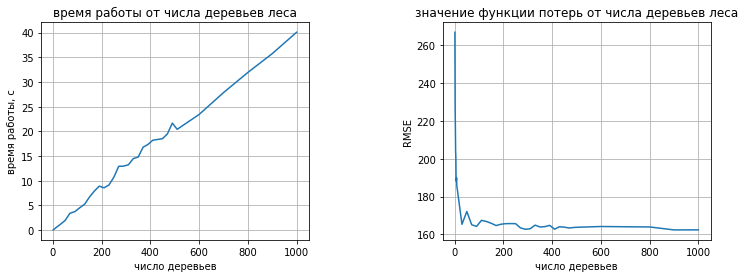

In [16]:
fig = plt.figure(figsize=(12, 4))
ax = plt.subplot(121)
ax1  = plt.subplot(122)
cl = ['r', 'g', 'b', 'y', 'c', 'orange', 'darkred', 'orange']
ax.plot(n_trees[:len(sc)], tm[:len(sc)])
ax1.plot(n_trees[:len(sc)], sc[:len(sc)])

ax1.set_xlabel('число деревьев')
ax.set_ylabel('время работы, c')
ax.set_title("время работы от числа деревьев леса")
ax1.grid()
ax.set_xlabel('число деревьев')
ax1.set_ylabel('RMSE')
ax1.set_title("значение функции потерь от числа деревьев леса")
ax.grid()

plt.subplots_adjust(wspace=0.5, hspace=0)


In [17]:
X_train.shape

(12096, 18)

In [35]:

n_features = np.arange(1, 19)
sc = []
tm = []

for i in n_features:
    sc_sum  = 0
    tm_sum = 0
    for j in range(1):
        start = time.time()
        model = RandomForestMSE(500, feature_subsample_size = i, max_depth = 20)
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        sc_sum += score(pred, y_test)
        end = time.time()
        tm_sum += end - start
    sc.append(sc_sum / 1)
    tm.append(tm_sum / 1)
    print(sc_sum / 1)

298.43815207193273
248.1954703212949
214.14714614123554
190.4438015165094
173.04549419921045
161.81572668075532
155.2715103742627
146.29699185689742
141.7890289968787
137.88475188478463
136.2843657119622
132.03965312499002
130.44455514883964
128.4725518716386
125.61249221594962
124.84068501383426
124.23278201058294
125.06893270110845


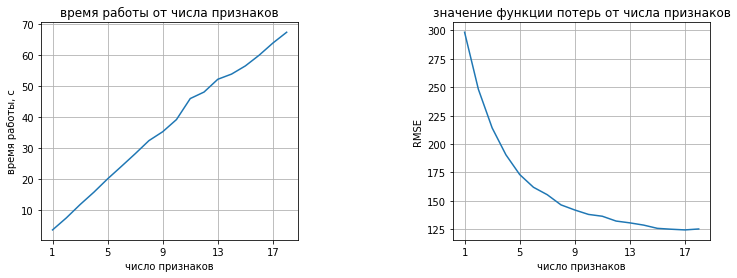

In [36]:
fig = plt.figure(figsize=(12, 4))
ax = plt.subplot(121)
ax1  = plt.subplot(122)
cl = ['r', 'g', 'b', 'y', 'c', 'orange', 'darkred', 'orange']
ax.plot(n_features[:len(sc)], tm[:len(sc)])
ax1.plot(n_features[:len(sc)], sc[:len(sc)])

ax1.set_xticks(np.arange(1, 19, 4))
ax.set_xticks(np.arange(1, 19, 4))

ax1.set_xlabel('число признаков')
ax.set_ylabel('время работы, c')
ax1.set_title("значение функции потерь от числа признаков")
ax1.grid()
ax.set_xlabel('число признаков')
ax1.set_ylabel('RMSE')
ax.set_title("время работы от числа признаков")
ax.grid()

plt.subplots_adjust(wspace=0.6, hspace=0)


In [25]:

n_depth = np.hstack((np.arange(1, 10, 2), np.arange(10, 30, 1)))
sc = []
tm = []

for i in n_depth:
    sc_sum  = 0
    tm_sum = 0
    for j in range(2):
        start = time.time()
        model = RandomForestMSE(500, max_depth = i)
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        sc_sum += score(pred, y_test)
        end = time.time()
        tm_sum += end - start
    sc.append(sc_sum / 2)
    tm.append(tm_sum / 2)
    print(sc_sum / 2)

280.1335621457615
218.0768260186047
189.61232863756345
175.44677328619014
170.59902182845462
167.9589338255289
166.04246989123084
164.0517144991316
165.35040543659
163.49964282140758
161.49650606301583
165.33289780488323
165.86910507058192
163.648856708435
162.0152629633563
162.54375268238078
162.12898099144962
164.1010076910139
162.17148507528475
164.1387136234954
163.34029701837915
161.2535809831633
160.98058723312235
162.50898373934376
162.9572894059325


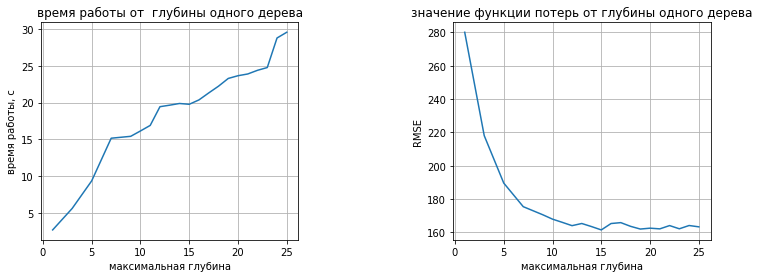

In [34]:
fig = plt.figure(figsize=(12, 4))
ax = plt.subplot(121)
ax1  = plt.subplot(122)
cl = ['r', 'g', 'b', 'y', 'c', 'orange', 'darkred', 'orange']
ax.plot(n_depth[:21], tm[:21])
ax1.plot(n_depth[:21], sc[:21])

ax1.set_xlabel('максимальная глубина')
ax.set_ylabel('время работы, c')
ax1.set_title("значение функции потерь от глубины одного дерева")
ax1.grid()
ax.set_xlabel('максимальная глубина')
ax1.set_ylabel('RMSE')
ax.set_title("время работы от  глубины одного дерева")
ax.grid()

plt.subplots_adjust(wspace=0.6, hspace=0)


In [38]:
model = RandomForestMSE(500)

model.fit(X_train, y_train)
score(model.predict(X_test), y_test)

162.84003715884896

In [43]:
model = RandomForestMSE(1000, feature_subsample_size = 17, max_depth = 20)


In [44]:
model.fit(X_train, y_train)

In [45]:
score(model.predict(X_test), y_test)

124.95475571783764

In [114]:
model = GradientBoostingMSE(500, feature_subsample_size = 1, max_depth = 1, learning_rate = 0.1)


In [115]:
model.fit(X_train, y_train)

In [116]:
score(model.predict(X_test), y_test)

379.1199372088963

In [40]:
n_trees = np.hstack((np.arange(1, 10), np.arange(10, 520, 20)))
n_trees = np.hstack((n_trees, np.arange(600, 1100, 100)))

sc_b = []
tm_b = []

for i in n_trees:
    sc_sum  = 0
    tm_sum = 0
    for j in range(3):
        start = time.time()
        model = GradientBoostingMSE(i, max_depth = 3)
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        sc_sum += score(pred, y_test)
        end = time.time()
        tm_sum += end - start
    sc_b.append(sc_sum / 3)
    tm_b.append(tm_sum / 3)
    print(sc_sum / 3)

344.35732607554746
328.5375641165552
316.63303030429034
305.15769013282517
291.9769853440109
277.618089809623
271.81456140946744
259.6590032038852
252.07733946905395
242.29906821873757
168.78878047600793
152.54116705742925
144.14837383978002
138.14345455167287
138.70764413656067
137.60747865395885
139.03594360347586
135.69582359760022
132.59659012630763
132.98424672535842
131.12613304249905
134.61572723750646
133.99841593338064
131.81648677065763
128.1069727823676
130.3226006134075
127.41768926620585
126.13172282055511
125.90152403436014
129.97512611209368
130.39092758399218
130.3367887072217
127.22349258079423
128.05401047040803
128.36882995905648
128.29098537124958
127.37429880163317
124.75464194888252
122.4344163847958
124.56768345199043


In [41]:
len(sc_b)

40

In [46]:
np.mean(sc_b[35])

128.29098537124958

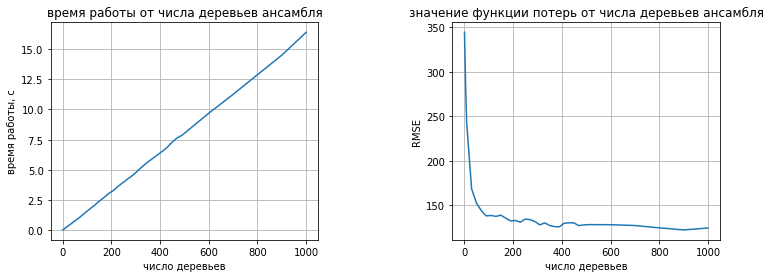

In [42]:
fig = plt.figure(figsize=(12, 4))
ax = plt.subplot(121)
ax1  = plt.subplot(122)
cl = ['r', 'g', 'b', 'y', 'c', 'orange', 'darkred', 'orange']
ax.plot(n_trees[:len(sc_b)], tm_b[:len(sc_b)])
ax1.plot(n_trees[:len(sc_b)], sc_b[:len(sc_b)])

ax1.set_xlabel('число деревьев')
ax.set_ylabel('время работы, c')
ax1.set_title("значение функции потерь от числа деревьев ансамбля")
ax1.grid()
ax.set_xlabel('число деревьев')
ax1.set_ylabel('RMSE')
ax.set_title("время работы от числа деревьев ансамбля")
ax.grid()

plt.subplots_adjust(wspace=0.5, hspace=0)


In [58]:

n_features = np.arange(1, 19, 1)
sc = []
tm = []

for i in n_features:
    sc_sum  = 0
    tm_sum = 0
    for j in range(3):
        start = time.time()
        model = GradientBoostingMSE(500, feature_subsample_size = i, max_depth = 4)
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        sc_sum += score(pred, y_test)
        end = time.time()
        tm_sum += end - start
    sc.append(sc_sum / 3)
    tm.append(tm_sum / 3)
    print(sc_sum / 3)

170.06609728633003
137.74475808836178
132.76385901737544
127.92598487656527
122.88492022982022
122.25021565984098
122.37925516103029
120.58541886616153
117.55385349373455
122.31917822337742
117.77965259892555
119.40534767774642
119.30494732205459
118.93279899840131
115.27530975206992
117.40936716223398
119.47193496342963
119.25241442819738


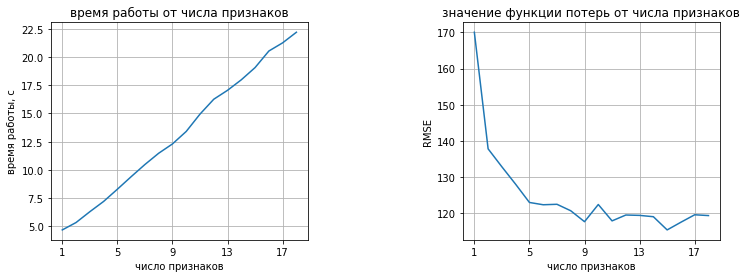

In [59]:
fig = plt.figure(figsize=(12, 4))
ax = plt.subplot(121)
ax1  = plt.subplot(122)
cl = ['r', 'g', 'b', 'y', 'c', 'orange', 'darkred', 'orange']
ax.plot(n_features, tm)
ax1.plot(n_features, sc)

ax1.set_xticks(np.arange(1, 19, 4))
ax.set_xticks(np.arange(1, 19, 4))

ax1.set_xlabel('число признаков')
ax.set_ylabel('время работы, c')
ax1.set_title("значение функции потерь от числа признаков")
ax1.grid()
ax.set_xlabel('число признаков')
ax1.set_ylabel('RMSE')
ax.set_title("время работы от числа признаков")
ax.grid()

plt.subplots_adjust(wspace=0.6, hspace=0)


In [48]:

n_features = np.arange(1, 10, 1)
sc = []
tm = []

for i in n_features:
    sc_sum  = 0
    tm_sum = 0
    for j in range(3):
        start = time.time()
        model = GradientBoostingMSE(500,  max_depth = i)
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        sc_sum += score(pred, y_test)
        end = time.time()
        tm_sum += end - start
    sc.append(sc_sum / 3)
    tm.append(tm_sum / 3)
    print(sc_sum / 3)

168.0330996870155
139.28086424814865
127.95977099893297
121.55939718657844
123.17604870838913
125.85042863341756
129.6277608082327
128.7182065491453
130.8209448904378


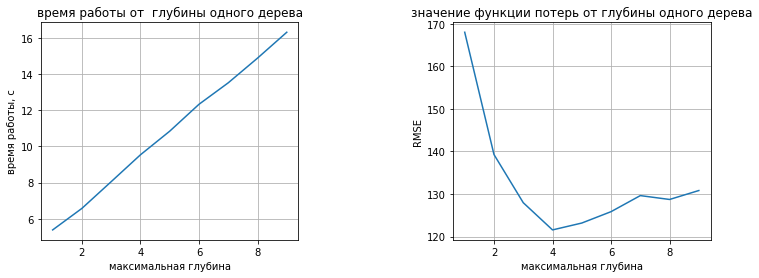

In [49]:
fig = plt.figure(figsize=(12, 4))
ax = plt.subplot(121)
ax1  = plt.subplot(122)
cl = ['r', 'g', 'b', 'y', 'c', 'orange', 'darkred', 'orange']
ax.plot(np.arange(1,10), tm)
ax1.plot(np.arange(1,10), sc)

ax1.set_xlabel('максимальная глубина')
ax.set_ylabel('время работы, c')
ax1.set_title("значение функции потерь от глубины одного дерева")
ax1.grid()
ax.set_xlabel('максимальная глубина')
ax1.set_ylabel('RMSE')
ax.set_title("время работы от  глубины одного дерева")
ax.grid()

plt.subplots_adjust(wspace=0.6, hspace=0)


In [52]:
model = GradientBoostingMSE(500)

model.fit(X_train, y_train)
score(model.predict(X_test), y_test)

130.91537962082762

In [14]:

l_r = [1e-5,  1e-4, 1e-3, 1e-2,  1e-1,  1]
sc = []
tm = []

for i in l_r:
    sc_sum  = 0
    tm_sum = 0
    for j in range(2):
        start = time.time()
        model = GradientBoostingMSE(500, feature_subsample_size = 15, max_depth = 4, learning_rate = i)
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        sc_sum += score(pred, y_test)
        end = time.time()
        tm_sum += end - start
    sc.append(sc_sum / 2)
    tm.append(tm_sum / 2)
    print(sc_sum / 2)

360.2677407344064
349.7862311359912
268.4370885937394
133.30607021621546
122.59847566576998
187.68834365678447


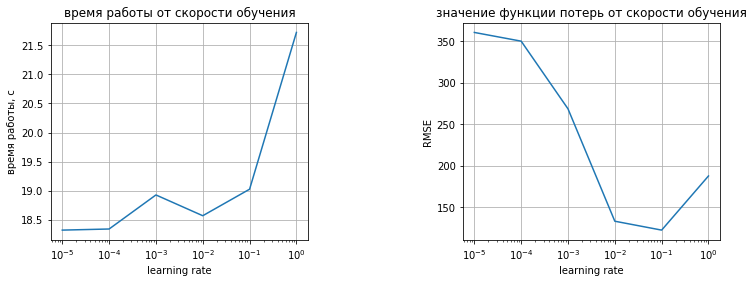

In [15]:
fig = plt.figure(figsize=(12, 4))
ax = plt.subplot(121)
ax1  = plt.subplot(122)
cl = ['r', 'g', 'b', 'y', 'c', 'orange', 'darkred', 'orange']
ax.plot(l_r, tm)
ax1.plot(l_r, sc)

ax.set_xscale('log')
ax1.set_xscale('log')

ax1.set_xlabel('learning rate')
ax.set_ylabel('время работы, c')
ax1.set_title("значение функции потерь от скорости обучения")
ax1.grid()
ax.set_xlabel('learning rate')
ax1.set_ylabel('RMSE')
ax.set_title("время работы от скорости обучения")
ax.grid()

plt.subplots_adjust(wspace=0.6, hspace=0)


In [62]:
p = tree.predict(X_test)

In [63]:
score(p, y_test)

379.1490565044665

In [17]:
model = GradientBoostingMSE(1000, max_depth = 4, feature_subsample_size = 15)

model.fit(X_train, y_train)
score(model.predict(X_test), y_test)

116.66420711706687